In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.optimize import fsolve
from scipy.special import rel_entr, kl_div
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
sunspot_ts = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv')
sunspot_ts.index = sunspot_ts['time'].values
sunspot_ts.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)
sunspot_ts.rename({'value': 'sunspot.year'}, axis=1, inplace=True)

In [3]:
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage_ts = wage.astype(int)

In [4]:
energy_df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption.csv',
                        sep=',', parse_dates=['Date'], dayfirst=False, index_col='Date')

energy_df = energy_df[energy_df.id == 2]
energy_df = energy_df['2010-01-01':'2015-05-13']
energy_df.dropna(axis=1, inplace=True)

energy_ts = energy_df.EnergyConsumption.astype(int)

In [294]:
def get_density_forecast(ts, horizon, base_alg, base_params={}, bins='auto', omega=None, fittedvalues=False):
    """
    Returns a list of density dictionaries {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    horizon : int
        The horizon to forecast.
    base_alg : {ExponentialSmoothing, SimpleExpSmoothing, Holt}
        The name of base algoritm for making density forecast.
    base_params : dict
        A Dictionary with base algorithm parameters.
    bins: int or sequence of scalars or str, optional
        Define how to calculate bins.
    fittedvalues: bool
        Include fitted values in density dictionaries or not.
    """
    
    if omega is not None:
        bins = omega
    
    alg = base_alg(ts, **base_params).fit()
    
    if fittedvalues:
        alg_preds = alg.predict(start=0, end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(len(ts) + horizon)]
    else:
        alg_preds = alg.predict(start=len(ts), end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(horizon)]
    
    for i in range(len(alg_preds)):
        density_dicts[i]['dotted_forecast'] = alg_preds.iloc[i]
        
        current_density = alg.resid + alg_preds.iloc[i]
        probs, bins = np.histogram(current_density, bins=bins)
        density_dicts[i]['probs'], density_dicts[i]['bins'] = probs / np.sum(probs), bins
    
    return density_dicts

In [295]:
def plot_density_forecast(ts, delay, base_alg, ax=None, **kwargs):
        
    density_dict = get_density_forecast(ts, delay, base_alg, **kwargs)[delay - 1]

    left_edges = density_dict['bins'][:-1]

    colors = []
    for i in range(len(left_edges) - 1):
        if left_edges[i] < density_dict['dotted_forecast'] < left_edges[i+1]:
            colors.append('coral')
        else:
            colors.append('royalblue')
    
    alg_name = str(base_alg)[str(base_alg).find('model.') + 6:-2]
    
    if ax:
        ax.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        ax.set_title(f'{alg_name}: density forecast with delay={delay}')
    else:
        plt.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        plt.title(f'{alg_name}: density forecast with delay={delay}')

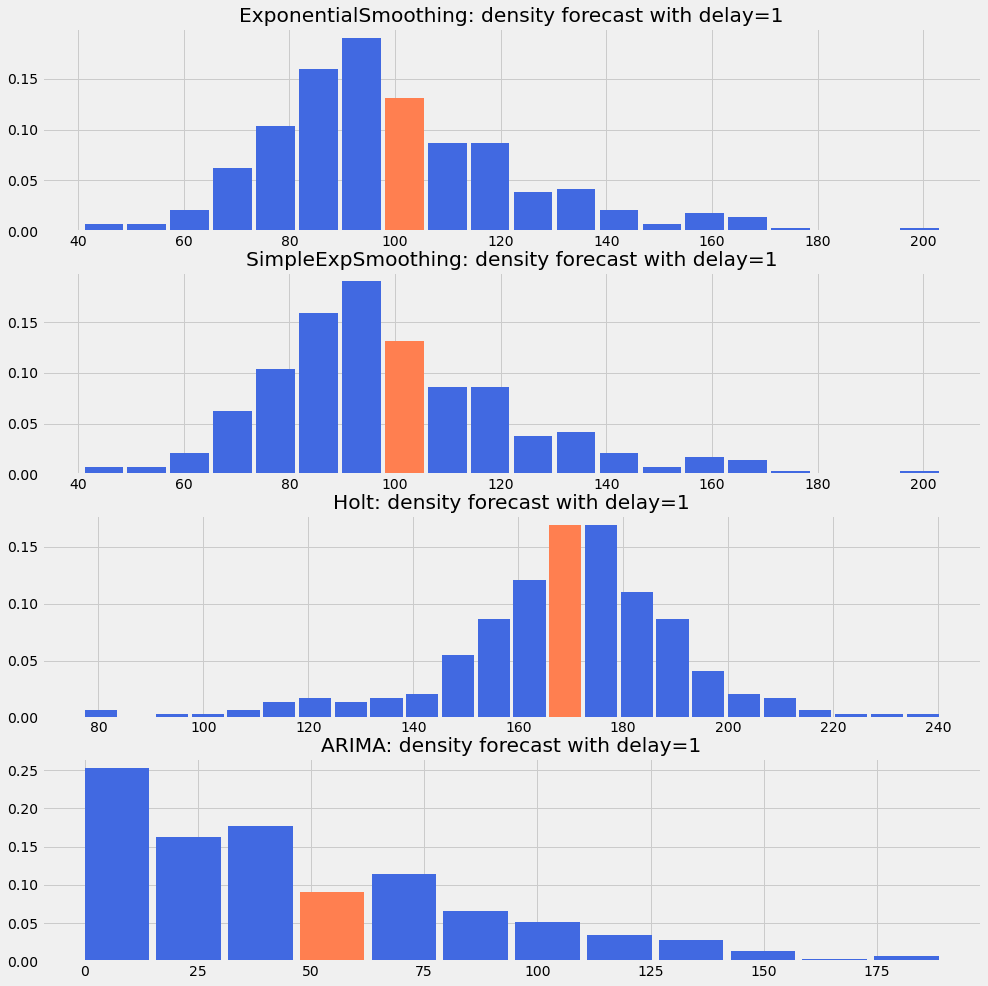

In [296]:
fig, ax = plt.subplots(4, figsize=(15,16))

for i, alg in enumerate([ExponentialSmoothing, SimpleExpSmoothing, Holt, ARIMA]):
    plot_density_forecast(sunspot_ts, 1, alg, ax=ax[i], bins='auto')

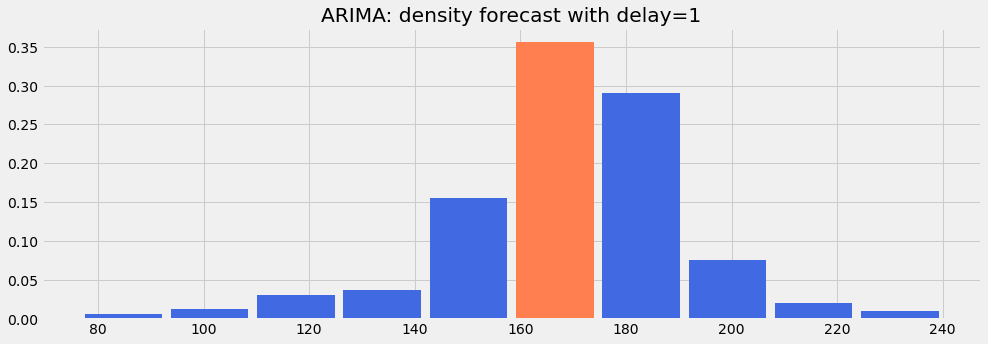

In [297]:
plt.figure(figsize=(15,5))
plot_density_forecast(sunspot_ts, 1, ARIMA, base_params={'order': (1, 2, 0)}, bins=10)

In [369]:
def get_omega(ts, mode, bins=None, quantile=0.1):
    if mode == "basic":
        return np.histogram_bin_edges(ts, bins)
    if mode == "quantile":
        bin_width = int(np.quantile(abs(ts - ts.shift(1))[1:], quantile))
    elif mode == "mean":
        bin_width = int(np.mean(abs(ts - ts.shift(1))[1:]))
    
    if bin_width < 1:
        bin_width = 1
    
    min_o = int(np.floor(min(ts.values)))
    max_o = int(np.ceil(max(ts.values)))
    
    bin_edges = [min_o]
    while bin_edges[-1] < max_o:
        bin_edges.append(bin_edges[-1] + bin_width)
    
    return np.array(bin_edges)

In [370]:
get_omega(sunspot_ts, mode="mean"), get_omega(sunspot_ts, mode="quantile")

(array([  0,  17,  34,  51,  68,  85, 102, 119, 136, 153, 170, 187, 204]),
 array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
         26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
         52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
         78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
        104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
        130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
        156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
        182, 184, 186, 188, 190, 192]))

In [441]:
def brier_loss(y_true, density_dict, p=2):
    """
    Returns np.array of brier scores.
    
    Parameters
    ----------
    y_true : float
        A true value.
    density_dict : dict
        Dict with bins and probabilities information.
    """
    bins_number = density_dict['probs'].size
    bins_true = [0] * bins_number

    for i in range(bins_number):
        if (density_dict['bins'][i] <= y_true <= density_dict['bins'][i + 1]):
            bins_true[i] = 1
            break
    
    brier_loss = np.sum((abs(density_dict['probs'] - bins_true))**p)
    
    if np.sum(bins_true) == 0:
        brier_loss += 1
        
    return brier_loss

In [442]:
def get_generalized_loss(y_true, density_dicts, loss_function, p):
    """
    Returns np.array of brier scores.
    
    Parameters
    ----------
    y_true : float
        A true value.
    density_dicts : dict or array-like of dicts
        Dicts with bins and probabilities information.
    """
    if type(density_dicts) == dict:
        density_dicts = [density_dicts]
    
    losses = [np.nan] * len(density_dicts)
    
    for density_dict_count, density_dict in enumerate(density_dicts):
        losses[density_dict_count] = loss_function(y_true, density_dict, p)
    
    return np.array(losses)

In [443]:
def avoid_overflowing(base, power_array):
    maximum = np.max(power_array)
    minimum = np.min(power_array)
    
    pmax = -np.log(base)/np.log(2) * maximum
    pmin = -np.log(base)/np.log(2) * minimum
    
    if np.abs(pmax-pmin) > 2097:
        print('Overflow is imminent. Further calculations are not advised')
        return base ** power_array
    power_shift = abs((51+pmin+pmax)/2)
    power_shift = power_shift + min(0, pmin - power_shift + 1023)
    
    power_array = power_array - np.abs(power_shift * np.log(2) / np.log(base))
    
    return base ** power_array

In [444]:
def get_generalized_prediction(ts, preds, omega, weights, loss_function, p, eta):
    generalized_predictions = []
    
    for w in zip(omega, omega[1:]):
        losses = get_generalized_loss((w[0] + w[1]) / 2, preds, loss_function, p)
        exp_losses = avoid_overflowing(np.e, -eta * losses)
        generalized_predictions.append(-(1 / eta) * np.log(np.sum(weights * exp_losses)))
        
    return np.array(generalized_predictions)

In [445]:
from scipy.optimize import fsolve

def s_equation(s, generalized_predictions, m=2):
    return np.sum([max(x,0) for x in s - generalized_predictions]) - m

In [446]:
def substitution_function(generalized_predictions, s, m=2):
    predictions = [max(x,0) / m for x in (s - generalized_predictions)]
    return np.array(predictions)

In [447]:
# def get_AA_density(omega_and_predictions, bins):
#     probs = [0] * (len(bins) - 1)
#     for i in range(len(bins) - 1):
#         for omega, pred in omega_and_predictions:
#             if bins[i] <= omega < bins[i + 1]:
#                 probs[i] += pred
#     return np.array(probs)

In [448]:
def update_weights(weights, losses, eta=1):
    exp_losses = avoid_overflowing(np.e, -eta * np.array(losses))
    new_weights = weights * exp_losses
    return new_weights / (np.sum(new_weights))

In [449]:
def aggregating_algorithm(ts, horizon, base_alg_dict, bins=10, omega_mode="basic",
                          loss_function=brier_loss, p=2, weights=None, eta=1):
    """
    Returns density dictionary {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    delay : int
        The delay to forecast.
    base_alg_dict : dict
        The dictionary with the names of base algoritms and their params:
        base_alg {ExponentialSmoothing, SimpleExpSmoothing, Holt} - name of base algorithm.
        base_alg_params : dict - a dictionary of base algorithm's parameters.
    loss_function : function
        The loss function of aggregating algorithm.
    """
    
    T = len(ts)
    K = len(base_alg_dict)
    
    AA_preds = [{} for i in range(T + horizon)]
    BA_preds = np.array([{} for i in range((T + horizon) * K)]).reshape(K, T + horizon) 
    
    if not weights:
        weights = np.full(K, 1/K)
    
    omega = get_omega(ts, mode=omega_mode, bins=bins) # здесь в Omega прогнозы не учитываются
 
    i = 0
    for base_alg, base_alg_params in base_alg_dict.items():
        BA_preds[i] = get_density_forecast(ts, horizon, base_alg, base_params=base_alg_params,
                                           omega=omega, fittedvalues=True)
        i += 1
        
        
    losses, prev_losses = None, None
        
    for t in tqdm(range(T + horizon)):
        preds = BA_preds[:, t]
        
        if not prev_losses:
            prev_losses = [loss_function(ts.values[t], pred, p) for pred in preds]  # cheat
              
        generalized_predictions = get_generalized_prediction(ts.values[:t], preds, omega,
                                                             weights, loss_function, p, eta)
        
        #solving the equation to find s
        s_init = np.max(generalized_predictions)
        s = fsolve(s_equation, s_init, args=generalized_predictions)
        
        #get real prediction with substitution function
        AA_preds[t]['bins'] = BA_preds[:, t][0]['bins']
        real_predictions = substitution_function(generalized_predictions, s)
        AA_preds[t]['probs'] = real_predictions
        
        #update weights 
        if t < T:            
            losses = [loss_function(ts.values[t], pred, p) for pred in preds]
            weights = update_weights(weights, losses, eta)

            prev_losses = losses
    
    return AA_preds

### Анализ результатов (AA vs Base Algorithms, AA vs Theoretical Boundary of Loss function)

**Sunspot TS**

In [450]:
omega = get_omega(sunspot_ts, mode="basic", bins=10)
Holt_preds = get_density_forecast(sunspot_ts, 3, Holt,
                                  omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(sunspot_ts, 3, SimpleExpSmoothing,
                                 omega=omega, fittedvalues=True)
AA_preds = aggregating_algorithm(sunspot_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="basic")

omega_mean = get_omega(sunspot_ts, mode="mean")
Holt_preds_mean = get_density_forecast(sunspot_ts, 3, Holt,
                                  omega=omega_mean, fittedvalues=True)
SES_preds_mean = get_density_forecast(sunspot_ts, 3, SimpleExpSmoothing,
                                 omega=omega_mean, fittedvalues=True)
AA_preds_mean = aggregating_algorithm(sunspot_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="mean")

omega_quant = get_omega(sunspot_ts, mode="quantile")
Holt_preds_quant = get_density_forecast(sunspot_ts, 3, Holt,
                                  omega=omega_quant, fittedvalues=True)
SES_preds_quant = get_density_forecast(sunspot_ts, 3, SimpleExpSmoothing,
                                 omega=omega_quant, fittedvalues=True)
AA_preds_quant = aggregating_algorithm(sunspot_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="quantile")

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

In [451]:
print(f"Holt: {Holt_preds[154]['probs']}")
print(f"SES: {SES_preds[154]['probs']}")
print(f"AA: {AA_preds[154]['probs']}")

Holt: [0.25868726 0.46332046 0.21621622 0.05019305 0.00772201 0.003861
 0.         0.         0.         0.        ]
SES: [0.15140845 0.3943662  0.24647887 0.12676056 0.04225352 0.03521127
 0.         0.00352113 0.         0.        ]
AA: [0.1959113  0.62434174 0.17974696 0.         0.         0.
 0.         0.         0.         0.        ]


In [452]:
Holt_losses = []
SES_losses = []
AA_losses = []
Holt_losses_mean = []
SES_losses_mean = []
AA_losses_mean = []
Holt_losses_quant = []
SES_losses_quant = []
AA_losses_quant = []
for i in range(len(sunspot_ts.values)):
    Holt_losses.append(brier_loss(sunspot_ts.values[i], Holt_preds[i]))
    SES_losses.append((brier_loss(sunspot_ts.values[i], SES_preds[i])))
    AA_losses.append((brier_loss(sunspot_ts.values[i], AA_preds[i])))
    Holt_losses_mean.append(brier_loss(sunspot_ts.values[i], Holt_preds_mean[i]))
    SES_losses_mean.append((brier_loss(sunspot_ts.values[i], SES_preds_mean[i])))
    AA_losses_mean.append((brier_loss(sunspot_ts.values[i], AA_preds_mean[i])))
    Holt_losses_quant.append(brier_loss(sunspot_ts.values[i], Holt_preds_quant[i]))
    SES_losses_quant.append((brier_loss(sunspot_ts.values[i], SES_preds_quant[i])))
    AA_losses_quant.append((brier_loss(sunspot_ts.values[i], AA_preds_quant[i])))

tb = np.minimum(Holt_losses, SES_losses)
tbln = np.minimum(Holt_losses, SES_losses) + np.full_like(sunspot_ts.index, np.log(2), dtype=float)
tb_mean = np.minimum(Holt_losses_mean, SES_losses_mean)
tbln_mean = np.minimum(Holt_losses_mean, SES_losses_mean) + np.full_like(sunspot_ts.index, np.log(2), dtype=float)
tb_quant = np.minimum(Holt_losses_quant, SES_losses_quant)
tbln_quant = np.minimum(Holt_losses_quant, SES_losses_quant) + np.full_like(sunspot_ts.index, np.log(2), dtype=float)

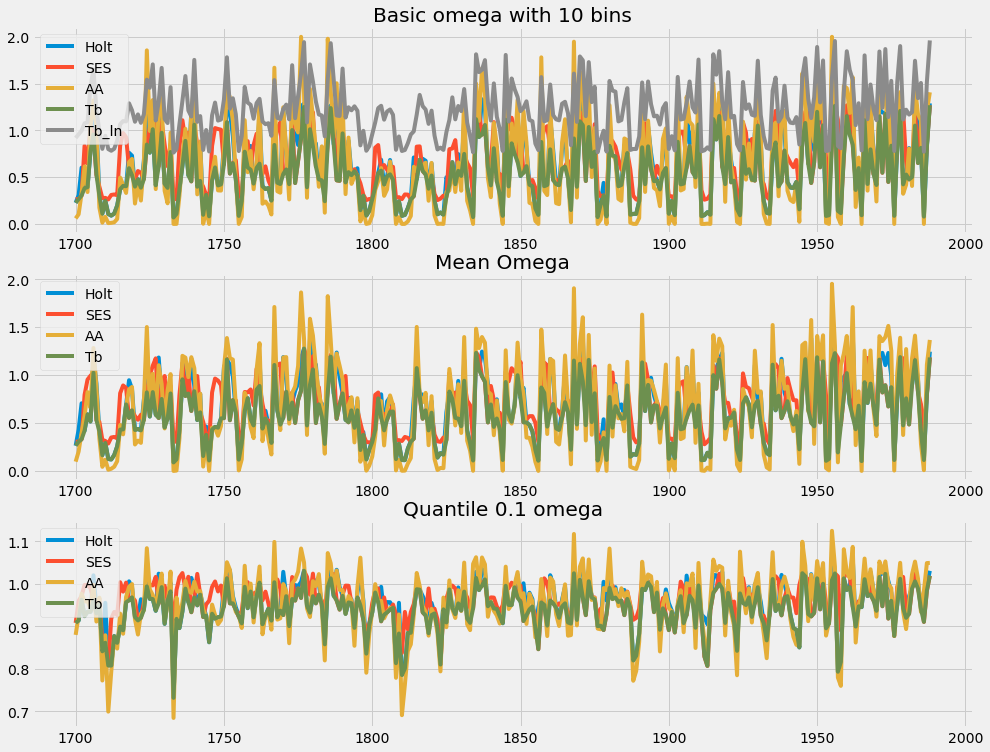

In [453]:
fig, ax = plt.subplots(nrows=3, figsize=(15,12))

ax[0].plot(sunspot_ts.index, Holt_losses)
ax[0].plot(sunspot_ts.index, SES_losses)
ax[0].plot(sunspot_ts.index, AA_losses)
ax[0].plot(sunspot_ts.index, tb)
ax[0].plot(sunspot_ts.index, tbln)
ax[0].set_title('Basic omega with 10 bins')
ax[0].legend(['Holt', 'SES', 'AA', 'Tb', 'Tb_ln'], loc='upper left');

ax[1].plot(sunspot_ts.index, Holt_losses_mean)
ax[1].plot(sunspot_ts.index, SES_losses_mean)
ax[1].plot(sunspot_ts.index, AA_losses_mean)
ax[1].plot(sunspot_ts.index, tb_mean)
ax[1].set_title('Mean Omega')
ax[1].legend(['Holt', 'SES', 'AA', 'Tb'], loc='upper left');

ax[2].plot(sunspot_ts.index, Holt_losses_quant)
ax[2].plot(sunspot_ts.index, SES_losses_quant)
ax[2].plot(sunspot_ts.index, AA_losses_quant)
ax[2].plot(sunspot_ts.index, tb_quant)
ax[2].set_title('Quantile 0.1 omega')
ax[2].legend(['Holt', 'SES', 'AA', 'Tb'], loc='upper left');

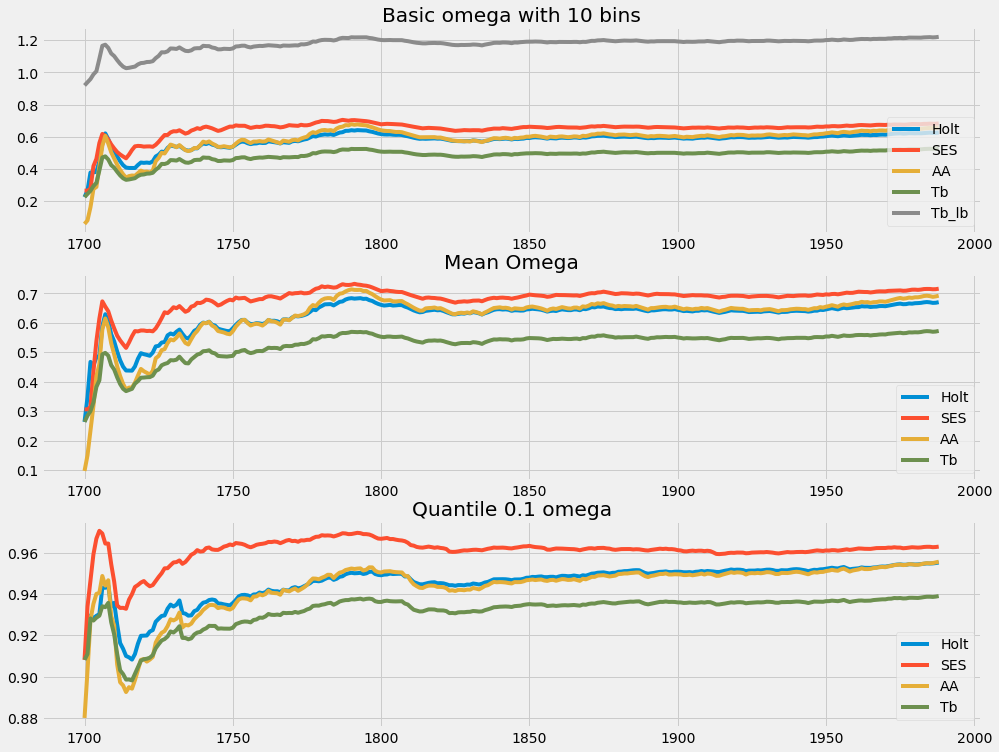

In [454]:
fig, ax = plt.subplots(3, figsize=(15,12))

ax[0].plot(sunspot_ts.index, np.cumsum(Holt_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(SES_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(AA_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(tb) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(tbln) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].set_title('Basic omega with 10 bins')
ax[0].legend(['Holt', 'SES', 'AA', 'Tb', 'Tb_lb'], loc='lower right');

ax[1].plot(sunspot_ts.index, np.cumsum(Holt_losses_mean) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(SES_losses_mean) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(AA_losses_mean) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(tb_mean) / list(range(1, len(sunspot_ts.values) + 1)))
# ax[1].plot(sunspot_ts.index, np.cumsum(tbln) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].set_title('Mean Omega')
ax[1].legend(['Holt', 'SES', 'AA', 'Tb'], loc='lower right');

ax[2].plot(sunspot_ts.index, np.cumsum(Holt_losses_quant) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(SES_losses_quant) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(AA_losses_quant) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(tb_quant) / list(range(1, len(sunspot_ts.values) + 1)))
# ax[2].plot(sunspot_ts.index, np.cumsum(tbln) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].set_title('Quantile 0.1 omega')
ax[2].legend(['Holt', 'SES', 'AA', 'Tb'], loc='lower right');

**Wage TS**

In [455]:
omega = get_omega(wage_ts, mode="basic", bins=10)
Holt_preds = get_density_forecast(wage_ts, 3, Holt,
                                  omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(wage_ts, 3, SimpleExpSmoothing,
                                 omega=omega, fittedvalues=True)
AA_preds = aggregating_algorithm(wage_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="basic")

omega_mean = get_omega(wage_ts, mode="mean")
Holt_preds_mean = get_density_forecast(wage_ts, 3, Holt,
                                  omega=omega_mean, fittedvalues=True)
SES_preds_mean = get_density_forecast(wage_ts, 3, SimpleExpSmoothing,
                                 omega=omega_mean, fittedvalues=True)
AA_preds_mean = aggregating_algorithm(wage_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="mean")

omega_quant = get_omega(wage_ts, mode="quantile")
Holt_preds_quant = get_density_forecast(wage_ts, 3, Holt,
                                  omega=omega_quant, fittedvalues=True)
SES_preds_quant = get_density_forecast(wage_ts, 3, SimpleExpSmoothing,
                                 omega=omega_quant, fittedvalues=True)
AA_preds_quant = aggregating_algorithm(wage_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="quantile")

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

In [456]:
Holt_losses = []
SES_losses = []
AA_losses = []
Holt_losses_mean = []
SES_losses_mean = []
AA_losses_mean = []
Holt_losses_quant = []
SES_losses_quant = []
AA_losses_quant = []
for i in range(len(wage_ts.values)):
    Holt_losses.append(brier_loss(wage_ts.values[i], Holt_preds[i]))
    SES_losses.append((brier_loss(wage_ts.values[i], SES_preds[i])))
    AA_losses.append((brier_loss(wage_ts.values[i], AA_preds[i])))
    Holt_losses_mean.append(brier_loss(wage_ts.values[i], Holt_preds_mean[i]))
    SES_losses_mean.append((brier_loss(wage_ts.values[i], SES_preds_mean[i])))
    AA_losses_mean.append((brier_loss(wage_ts.values[i], AA_preds_mean[i])))
    Holt_losses_quant.append(brier_loss(wage_ts.values[i], Holt_preds_quant[i]))
    SES_losses_quant.append((brier_loss(wage_ts.values[i], SES_preds_quant[i])))
    AA_losses_quant.append((brier_loss(wage_ts.values[i], AA_preds_quant[i])))

tb = np.minimum(Holt_losses, SES_losses)
tbln = np.minimum(Holt_losses, SES_losses) + np.full_like(sunspot_ts.index, np.log(2), dtype=float)
tb_mean = np.minimum(Holt_losses_mean, SES_losses_mean)
tbln_mean = np.minimum(Holt_losses_mean, SES_losses_mean) + np.full_like(sunspot_ts.index, np.log(2), dtype=float)
tb_quant = np.minimum(Holt_losses_quant, SES_losses_quant)
tbln_quant = np.minimum(Holt_losses_quant, SES_losses_quant) + np.full_like(sunspot_ts.index, np.log(2), dtype=float)

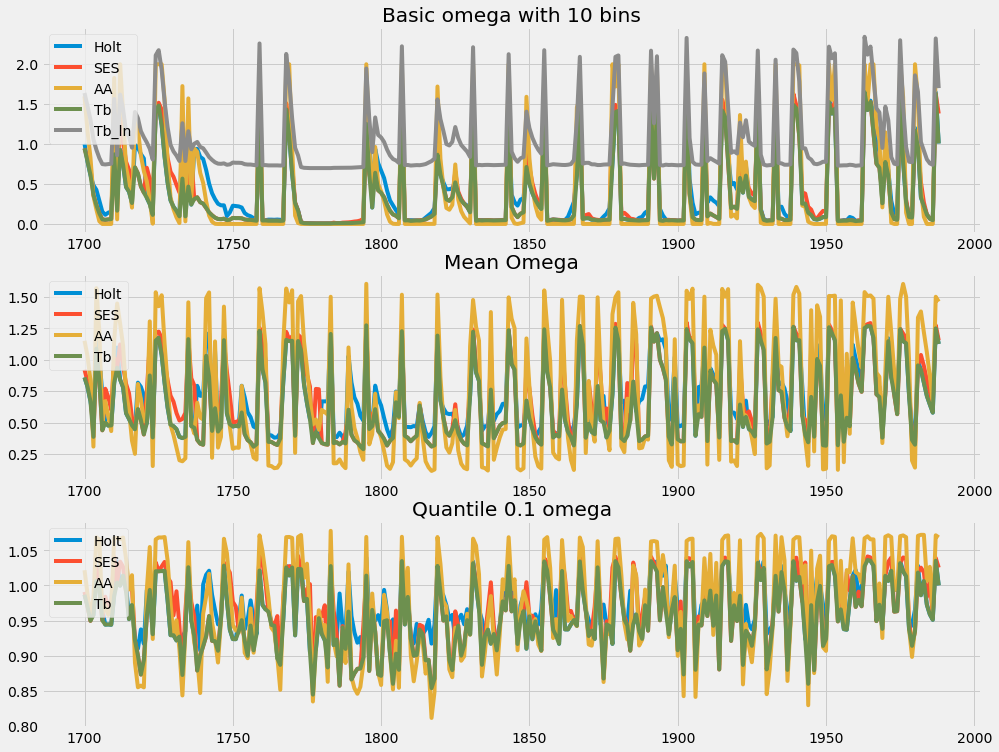

In [457]:
fig, ax = plt.subplots(nrows=3, figsize=(15,12))

ax[0].plot(sunspot_ts.index, Holt_losses)
ax[0].plot(sunspot_ts.index, SES_losses)
ax[0].plot(sunspot_ts.index, AA_losses)
ax[0].plot(sunspot_ts.index, tb)
ax[0].plot(sunspot_ts.index, tbln)
ax[0].set_title('Basic omega with 10 bins')
ax[0].legend(['Holt', 'SES', 'AA', 'Tb', 'Tb_ln'], loc='upper left');

ax[1].plot(sunspot_ts.index, Holt_losses_mean)
ax[1].plot(sunspot_ts.index, SES_losses_mean)
ax[1].plot(sunspot_ts.index, AA_losses_mean)
ax[1].plot(sunspot_ts.index, tb_mean)
ax[1].set_title('Mean Omega')
ax[1].legend(['Holt', 'SES', 'AA', 'Tb'], loc='upper left');

ax[2].plot(sunspot_ts.index, Holt_losses_quant)
ax[2].plot(sunspot_ts.index, SES_losses_quant)
ax[2].plot(sunspot_ts.index, AA_losses_quant)
ax[2].plot(sunspot_ts.index, tb_quant)
ax[2].set_title('Quantile 0.1 omega')
ax[2].legend(['Holt', 'SES', 'AA', 'Tb'], loc='upper left');

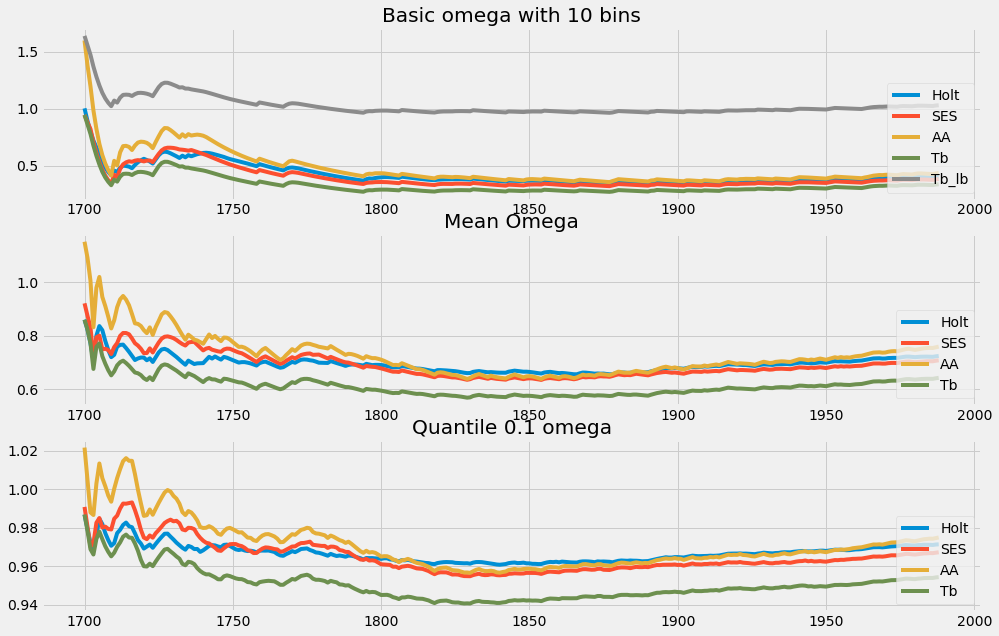

In [458]:
fig, ax = plt.subplots(3, figsize=(15,10))

ax[0].plot(sunspot_ts.index, np.cumsum(Holt_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(SES_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(AA_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(tb) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(tbln) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].set_title('Basic omega with 10 bins')
ax[0].legend(['Holt', 'SES', 'AA', 'Tb', 'Tb_lb'], loc='lower right');

ax[1].plot(sunspot_ts.index, np.cumsum(Holt_losses_mean) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(SES_losses_mean) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(AA_losses_mean) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(tb_mean) / list(range(1, len(sunspot_ts.values) + 1)))
# ax[1].plot(sunspot_ts.index, np.cumsum(tbln) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].set_title('Mean Omega')
ax[1].legend(['Holt', 'SES', 'AA', 'Tb'], loc='lower right');

ax[2].plot(sunspot_ts.index, np.cumsum(Holt_losses_quant) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(SES_losses_quant) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(AA_losses_quant) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(tb_quant) / list(range(1, len(sunspot_ts.values) + 1)))
# ax[2].plot(sunspot_ts.index, np.cumsum(tbln) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].set_title('Quantile 0.1 omega')
ax[2].legend(['Holt', 'SES', 'AA', 'Tb'], loc='lower right');

### Зависимость абсолютной величины brier loss от количества бинов

In [459]:
losses_dict = {}

for bins in tqdm(range(1, 31)):
    preds = aggregating_algorithm(sunspot_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                  omega_mode="basic", bins=bins)
    
    loss = 0
    for i in range(len(sunspot_ts.values)):
        loss += brier_loss(sunspot_ts.values[i], preds[i])
        
    losses_dict[bins] = loss / len(sunspot_ts.values)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

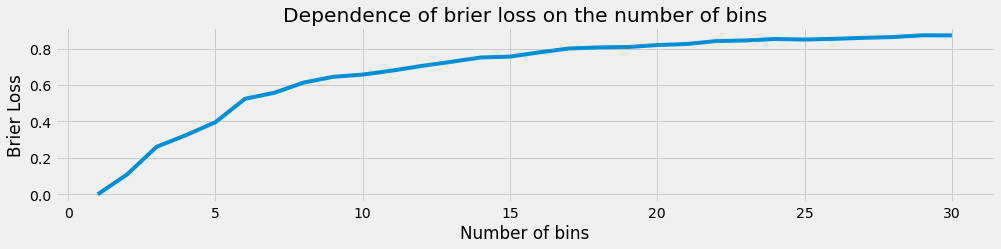

In [460]:
plt.figure(figsize=(15,3))

plt.plot(losses_dict.keys(), losses_dict.values())
plt.title('Dependence of brier loss on the number of bins')
plt.ylabel('Brier Loss')
plt.xlabel('Number of bins');

### Другие точечные метрики прогноза

**1. В обучение p=2; качество измеряем с p=2 и p=1**

  0%|          | 0/292 [00:00<?, ?it/s]

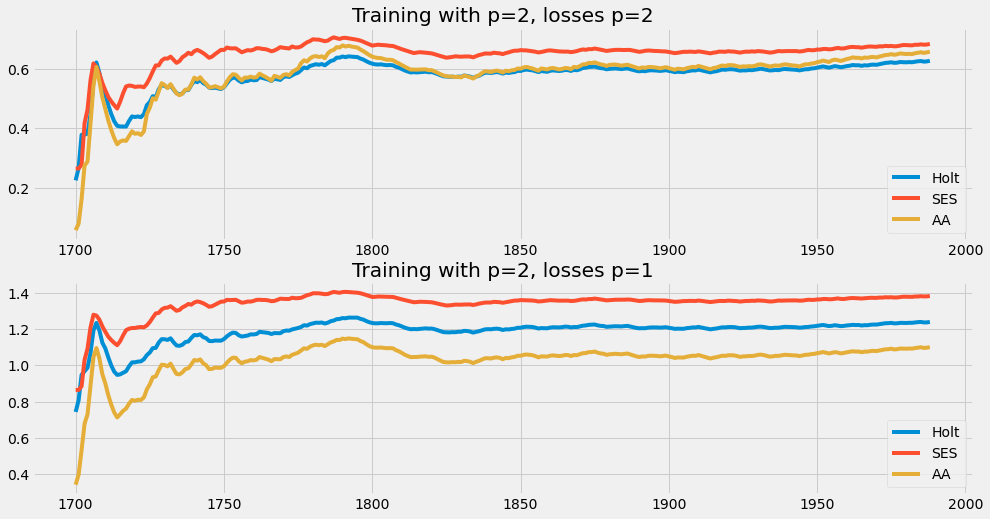

In [463]:
omega = get_omega(sunspot_ts, mode="basic", bins=10)
Holt_preds = get_density_forecast(sunspot_ts, 3, Holt,
                                  omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(sunspot_ts, 3, SimpleExpSmoothing,
                                 omega=omega, fittedvalues=True)
AA_preds = aggregating_algorithm(sunspot_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="basic", p=2)

Holt_losses2 = []
SES_losses2 = []
AA_losses2 = []
Holt_losses1 = []
SES_losses1 = []
AA_losses1 = []
for i in range(len(sunspot_ts.values)):
    Holt_losses2.append(brier_loss(sunspot_ts.values[i], Holt_preds[i]))
    SES_losses2.append((brier_loss(sunspot_ts.values[i], SES_preds[i])))
    AA_losses2.append((brier_loss(sunspot_ts.values[i], AA_preds[i])))
    
    Holt_losses1.append(brier_loss(sunspot_ts.values[i], Holt_preds[i], p=1))
    SES_losses1.append((brier_loss(sunspot_ts.values[i], SES_preds[i], p=1)))
    AA_losses1.append((brier_loss(sunspot_ts.values[i], AA_preds[i], p=1)))
    
fig, ax = plt.subplots(2, figsize=(15,8))

ax[0].plot(sunspot_ts.index, np.cumsum(Holt_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(SES_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(AA_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].set_title('Training with p=2, losses p=2')
ax[0].legend(['Holt', 'SES', 'AA', 'Tb', 'Tb_lb'], loc='lower right');

ax[1].plot(sunspot_ts.index, np.cumsum(Holt_losses1) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(SES_losses1) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(AA_losses1) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].set_title('Training with p=2, losses p=1')
ax[1].legend(['Holt', 'SES', 'AA', 'Tb'], loc='lower right');

**1. В обучение p=1; качество измеряем с p=2 и p=1**

  0%|          | 0/292 [00:00<?, ?it/s]

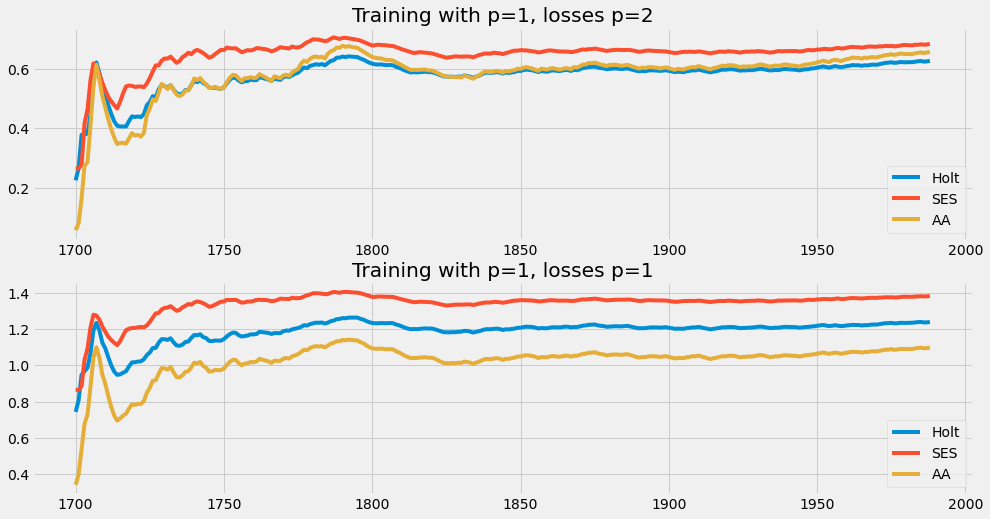

In [464]:
omega = get_omega(sunspot_ts, mode="basic", bins=10)
Holt_preds = get_density_forecast(sunspot_ts, 3, Holt,
                                  omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(sunspot_ts, 3, SimpleExpSmoothing,
                                 omega=omega, fittedvalues=True)
AA_preds = aggregating_algorithm(sunspot_ts, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                 bins=10, omega_mode="basic", p=1)

Holt_losses2 = []
SES_losses2 = []
AA_losses2 = []
Holt_losses1 = []
SES_losses1 = []
AA_losses1 = []
for i in range(len(sunspot_ts.values)):
    Holt_losses2.append(brier_loss(sunspot_ts.values[i], Holt_preds[i]))
    SES_losses2.append((brier_loss(sunspot_ts.values[i], SES_preds[i])))
    AA_losses2.append((brier_loss(sunspot_ts.values[i], AA_preds[i])))
    
    Holt_losses1.append(brier_loss(sunspot_ts.values[i], Holt_preds[i], p=1))
    SES_losses1.append((brier_loss(sunspot_ts.values[i], SES_preds[i], p=1)))
    AA_losses1.append((brier_loss(sunspot_ts.values[i], AA_preds[i], p=1)))
    
fig, ax = plt.subplots(2, figsize=(15,8))

ax[0].plot(sunspot_ts.index, np.cumsum(Holt_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(SES_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(AA_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].set_title('Training with p=1, losses p=2')
ax[0].legend(['Holt', 'SES', 'AA', 'Tb', 'Tb_lb'], loc='lower right');

ax[1].plot(sunspot_ts.index, np.cumsum(Holt_losses1) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(SES_losses1) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(AA_losses1) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].set_title('Training with p=1, losses p=1')
ax[1].legend(['Holt', 'SES', 'AA', 'Tb'], loc='lower right');

### Гистограммные метрики точности прогноза

Kullback-Leibler divergence

In [35]:
AA_preds[0]['bins']

array([ 48. ,  74.8, 101.6, 128.4, 155.2, 182. , 208.8, 235.6, 262.4,
       289.2, 316. ])

In [36]:
from scipy.special import rel_entr, kl_div

In [37]:
rel_entr(AA_preds[0]['probs'], AA_preds[1]['probs'])

array([ 0.        , -0.00317371,  0.00534786,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [38]:
rel_entr(np.histogram(wage_ts.values, bins=10, density=True)[0], AA_preds[-1]['probs'])

array([        inf,         inf,         inf,         inf,         inf,
               inf, -0.00349619, -0.00686394,         inf,         inf])

Sharpness (Negative Log-likelihood)

In [39]:
# def NLL(density_dict, omega=None, base=np.e):
#     probs = (np.roll(density_dict['bins'], -1) - density_dict['bins'])[:-1] * density_dict['probs']
    
#     if omega:
#         for x in omega:
#     else:
#         nll = -np.log(probs) / np.log(base)
# #         nll = np.where(nll==np.inf, 0, nll) 
    
#     return nll

In [40]:
np.diff(AA_preds[10]['bins']) * (AA_preds[10]['probs'])

array([0.        , 0.05753706, 0.94246294, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

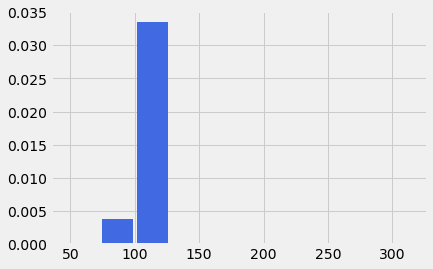

In [41]:
left_edges = AA_preds[0]['bins'][:-1]

plt.bar(left_edges, AA_preds[0]['probs'], align='edge',
        width=0.9*(left_edges[1] - left_edges[0]), color='royalblue');